In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from tqdm.notebook import tqdm

# On désactive l'import direct de DQN pour le remplacer
# from stable_baselines3 import DQN  
from stable_baselines3.common.vec_env import DummyVecEnv

# ===================================
# LIGNES AJOUTÉES pour le Double DQN 
# (Custom) 
# ===================================
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3.common.off_policy_algorithm import OffPolicyAlgorithm
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.utils import polyak_update
import pickle


import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.chdir("../")

from Src.utils import *
from Src.BollingerBaselineAgent import BollingerBaselineAgent
from Src.TradingEnvironment import CommodityTradingEnv

# Load data

In [2]:
commodities = ['GC=F', 'SI=F', 'NG=F']

commodities_data = get_commodities_data(commodities)

# Définition des périodes
training_data_time_range = ('2010-01-01', '2017-12-31')
validation_data_time_range = ('2018-01-01', '2019-12-31')
test_data_time_range = ('2020-01-01', '2023-01-01')

training_data = {}
validation_data = {}
test_data = {}

for ticker, df in commodities_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]].copy()
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]].copy()
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]].copy()

print("Shapes pour GC=F (Training, Validation, Test) :", 
      training_data['GC=F'].shape, validation_data['GC=F'].shape, test_data['GC=F'].shape)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shapes pour GC=F (Training, Validation, Test) : (2011, 5) (502, 5) (756, 5)


In [3]:
# # Ajout des indicateurs
# for ticker in commodities:
#     commodities_data[ticker] = add_bollinger_bands(commodities_data[ticker])

In [3]:
for ticker in training_data:
    training_data[ticker] = add_technical_indicators(training_data[ticker])
for ticker in validation_data:
    validation_data[ticker] = add_technical_indicators(validation_data[ticker])
for ticker in test_data:
    test_data[ticker] = add_technical_indicators(test_data[ticker])

print(training_data['GC=F'].head())

Price              Open         High          Low        Close    Volume  \
Ticker             GC=F         GC=F         GC=F         GC=F      GC=F   
Date                                                                       
2010-02-01  1081.000000  1107.300049  1076.800049  1104.300049  0.903026   
2010-02-02  1117.400024  1118.500000  1100.199951  1117.400024  0.935696   
2010-02-03  1115.800049  1124.900024  1108.599976  1111.400024  0.423703   
2010-02-04  1110.000000  1110.699951  1059.000000  1062.400024  0.571229   
2010-02-05  1052.199951  1068.500000  1045.199951  1052.199951  0.616585   

Price            MACD    Signal        RSI         CCI        ADX  \
Ticker                                                              
Date                                                                
2010-02-01  -8.662289 -5.106665  34.836633  -65.366222  28.495614   
2010-02-02  -6.795084 -5.444349  46.015247  -10.964782  26.065814   
2010-02-03  -5.733371 -5.502153  41.246502   -

In [4]:
env_train = DummyVecEnv([lambda: CommodityTradingEnv(training_data, transaction_cost_percent=0.005)])
env_val = DummyVecEnv([lambda: CommodityTradingEnv(validation_data, transaction_cost_percent=0.005)])
env_test = DummyVecEnv([lambda: CommodityTradingEnv(test_data, transaction_cost_percent=0.005)])

# Load Agents

## Boillinger

In [6]:
best_model_path = "Results/best_bollinger_baseline_agent.pkl"
best_model_bollinger = BollingerBaselineAgent.load(best_model_path)

max_days = env_test.envs[0].max_steps - 1  # Nombre d'étapes dans l'environnement de test
test_metrics = test_agent(env_test, best_model_bollinger, n_tests=max_days, visualize=False)  # Test de l'agent

d:\Developpement\RL_3A_CS\Trading_bot_Reinforcement_Learning\Src\TradingEnvironment.py:98: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price = float(self.commodity_data[ticker]['Close'].iloc[self.current_step])


In [9]:
profits = [i-10000 for i in test_metrics["net_worths"]]
metrics = calculate_metrics(profits)

# Affichage des résultats
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

E(R): 3919.02
std(R): 3447.47
Downside Deviation (DD): 390.28
Sharpe Ratio: 1.14
Sortino Ratio: 10.04
MDD: nan
Calmar Ratio: nan
% +ve Returns: 90.88
Ave. P / Ave. L: 11.06


d:\Developpement\RL_3A_CS\Trading_bot_Reinforcement_Learning\Src\utils.py:30: RuntimeWarning: divide by zero encountered in divide
  drawdowns = (cumulative_returns - running_max) / running_max
d:\Developpement\RL_3A_CS\Trading_bot_Reinforcement_Learning\Src\utils.py:30: RuntimeWarning: invalid value encountered in divide
  drawdowns = (cumulative_returns - running_max) / running_max


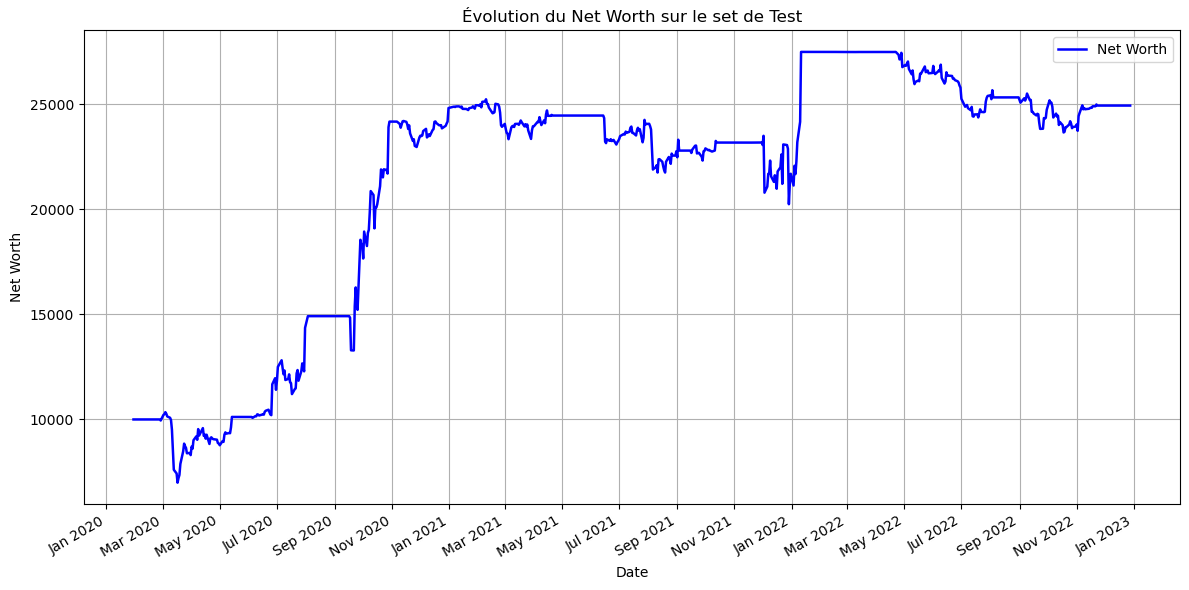

In [7]:
# Affichage de l'évolution du Net Worth
plot_net_worth(test_metrics=test_metrics, env=env_test)